# LSTM ...

### Python Library ...

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense,Dropout, LSTM
from tensorflow.keras.optimizers import Adam,SGD

from matplotlib import pyplot as plt


### Load All The Data....

In [2]:
# Load the data
file_path = 'Data/All_Data.xlsx'  # Replace with your file path
data_01 = pd.read_excel(file_path)

### Creating Synthetic Data ....

In [3]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

# Original dataset (features only)
# X = np.array([[1, 2], [2, 3], [3, 4], [5, 6]])
Data = data_01.loc[:, 'Average ROM Angle':90].values 

# Number of synthetic samples to generate
num_synthetic_samples = 100

# Fit KNN to find nearest neighbours
knn = NearestNeighbors(n_neighbors=2)  # Use 2 neighbours for simplicity
knn.fit(Data)

# Generate synthetic samples
synthetic_samples = []
for _ in range(num_synthetic_samples):
    # Randomly pick a data point from X
    idx = np.random.randint(0, Data.shape[0])
    point = Data[idx]

    # Find neighbours of the point
    neighbours = knn.kneighbors([point], return_distance=False)[0]
    
    # Randomly choose one neighbour
    neighbour = Data[neighbours[np.random.randint(1, len(neighbours))]]  # Skip self (idx=0)
    
    # Interpolate between the point and the neighbour
    alpha = np.random.uniform(0, 1)  # Random weight for interpolation
    synthetic_point = (point + alpha * (neighbour - point))
    
    synthetic_samples.append(synthetic_point)

# Combine original and synthetic samples
synthetic_samples = np.array(synthetic_samples)
augmented_dataset = np.vstack([Data, synthetic_samples])

# print("Original Data:\n", Data.shape)
# print("Synthetic Data:\n", synthetic_samples.shape)
# print("Augmented Dataset:\n", augmented_dataset.shape)

In [4]:
data = pd.DataFrame(augmented_dataset)
# data.head()

### Extract EEG features and target...

In [5]:
# Extract EEG features and target
X = data.loc[:, 1:181].values  # EEG data (columns D to MI) iloc[:,3:]
y = data.loc[:, 0].values  # Target ROM angle (column C)
max_rom = y.max()
min_rom = y.min()
# Check for extreme values in target
print(f"Max ROM Angle: {max_rom}, Min ROM Angle: {min_rom}")

# Normalise the target variable
y = (y - min_rom) / (max_rom - min_rom)


Max ROM Angle: 155.0, Min ROM Angle: 105.0


### Normalise the features...

In [6]:
# Normalise the features
scaler = MinMaxScaler()
X_normalised = scaler.fit_transform(X)

# Reshape X for GRU (samples, timesteps, features)
n_features = X_normalised.shape[1]
X_reshaped = X_normalised.reshape(X_normalised.shape[0], 1, n_features)

### Split data into training and testing sets ...

In [7]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.1, random_state= 4)

### R2 function...

In [8]:
import tensorflow.keras.backend as K

def r_squared(y_true, y_pred):
    ss_res = K.sum(K.square(y_true - y_pred))
    ss_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return 1 - ss_res / (ss_tot + K.epsilon())

# LSTM ...

In [9]:

# Build the LSTM model
model = Sequential([
    LSTM(96, return_sequences=True, input_shape=(X_reshaped.shape[1], X_reshaped.shape[2])),
    Dropout(0.2),
    LSTM(96, return_sequences=True),
    Dropout(0.2),
    LSTM(96, return_sequences=True),
    Dropout(0.1),
    LSTM(96, return_sequences=False),
    Dropout(0.1),
    # Dense(32, activation='relu'),
    Dense(1)  # Single output for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0005, clipnorm=1.0),  # Gradient clipping
              loss='mse', 
              metrics=['mae']) # ,r_squared])



In [10]:
# Train the model
history = model.fit(X_train, y_train, epochs=300, batch_size=1, validation_data=(X_test, y_test))

Epoch 1/300
114/114 [==============================] - 7s 21ms/step - loss: 0.1267 - mae: 0.2762 - val_loss: 0.0310 - val_mae: 0.1642
Epoch 2/300
114/114 [==============================] - 1s 11ms/step - loss: 0.0304 - mae: 0.1395 - val_loss: 0.0337 - val_mae: 0.1582
Epoch 3/300
114/114 [==============================] - 1s 10ms/step - loss: 0.0335 - mae: 0.1430 - val_loss: 0.0246 - val_mae: 0.1399
Epoch 4/300
114/114 [==============================] - 1s 11ms/step - loss: 0.0274 - mae: 0.1346 - val_loss: 0.0224 - val_mae: 0.1326
Epoch 5/300
114/114 [==============================] - 1s 11ms/step - loss: 0.0288 - mae: 0.1366 - val_loss: 0.0349 - val_mae: 0.1523
Epoch 6/300
114/114 [==============================] - 1s 11ms/step - loss: 0.0241 - mae: 0.1263 - val_loss: 0.0209 - val_mae: 0.1228
Epoch 7/300
114/114 [==============================] - 1s 12ms/step - loss: 0.0233 - mae: 0.1203 - val_loss: 0.0260 - val_mae: 0.1289
Epoch 8/300
114/114 [==============================] - 1s 10ms

## Training Graphs...

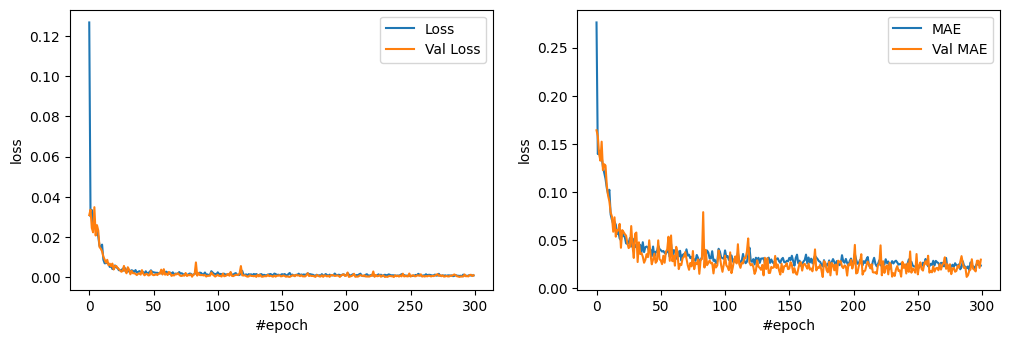

In [11]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'],label='Loss')
plt.plot(history.history['val_loss'],label='Val Loss')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('loss')

plt.subplot(2, 2, 2)
plt.plot(history.history['mae'],label='MAE')
plt.plot(history.history['val_mae'],label='Val MAE')
plt.legend()
plt.xlabel('#epoch')
plt.ylabel('loss')

# plt.subplot(2,2,3)
# plt.plot(history.history['r_squared'],label='R_2')
# plt.plot(history.history['val_r_squared'],label='Val R2')
# plt.legend()
# plt.xlabel('#epoch')
# plt.ylabel('R2')

plt.show()

### Results Analysis...

In [12]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions
predictions = model.predict(X_test)

r2 = r2_score(y_test,predictions)
mae = mean_absolute_error(y_test,predictions)
mse = mean_squared_error(y_test,predictions)

print(f'R2 score: {r2*100:2f}%')
print(f'MAE : {mae:5f}')
print(f'MSE : {mse:5f}')

R2 score: 95.969567%
MAE : 0.029817
MSE : 0.001135


### Invers The Metrix...

In [13]:
# Function for invers metrixes...
def invers_prediction(predic):
    prz = predic
    Predictions = []
    for i in range(prz.shape[0]):
        pred = prz[i]*(max_rom-min_rom) + min_rom
        Predictions.append(pred)

    return Predictions


In [14]:
inv_predicted = invers_prediction(predictions)
prediction_list = [float(arr[0]) for arr in inv_predicted] 
# predicteded_list = [[value] for value in prediction_list]
# prediction_list
inver_y_test = invers_prediction(y_test)


In [ ]:
r2=r2_score(inver_y_test,prediction_list)
mae = mean_absolute_error(inver_y_test,prediction_list)
mse = mean_squared_error(inver_y_test,prediction_list)

print(f'R2 score: {r2*100:2f}%')
print(f'MAE : {mae:5f}')
print(f'MSE : {mse:5f}')

In [15]:
pd_result_table = pd.DataFrame(data = [inver_y_test,prediction_list], index = ["y-test","prd"])
pd_result_table

,0,1,2,3,4,5,6,7,8,9,10,11,12
y-test,142.581905,134.600000,146.660000,131.700000,137.629237,135.000000,127.050785,135.600000,140.104046,121.600000,137.702246,131.658993,113.911423
prd,141.153595,134.304871,144.381165,132.528748,137.095032,132.380569,128.932419,134.016983,138.927200,122.803841,137.112030,134.461884,116.069069


### Save the model...

In [16]:
# Save the model
model.save('lstm_rom_prediction_model_01.h5')